In [7]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns; sns.set()

In [8]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [9]:
train = train[::-1]
test = test[::-1]

In [10]:
train.head()

,Date,Open,High,Low,Close,Volume,Market Cap
1555,"Apr 28, 2013",135.30,135.98,132.10,134.21,-,"1,500,520,000"
1554,"Apr 29, 2013",134.44,147.49,134.00,144.54,-,"1,491,160,000"
1553,"Apr 30, 2013",144.00,146.93,134.05,139.00,-,"1,597,780,000"
1552,"May 01, 2013",139.00,139.89,107.72,116.99,-,"1,542,820,000"
1551,"May 02, 2013",116.38,125.60,92.28,105.21,-,"1,292,190,000"


In [11]:
df = pd.concat((train,test),axis=0)

In [12]:
df.Open.values

array([  135.3 ,   134.44,   144.  , ...,  2897.63,  3257.61,  3212.78])

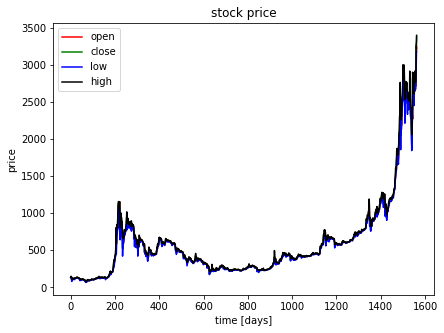

In [13]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df.Open.values, color='red', label='open')
plt.plot(df.Close.values, color='green', label='close')
plt.plot(df.Low.values, color='blue', label='low')
plt.plot(df.High.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

In [14]:
train = train['Close'].values.astype('float32')
test = test['Close'].values.astype('float32')

# Make sure to standardize the data before feeding it to neural nets

In [15]:
from sklearn.preprocessing import StandardScaler

C:\Users\Acer\Anaconda3\envs\kerasenv\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [16]:
# reshape data to scale the point
train = train.reshape(-1, 1)
test = test.reshape(-1, 1)

scaler = StandardScaler()
train_n = scaler.fit_transform(train)
test_n = scaler.transform(test)

In [17]:
print(train_n.shape)
print(test_n.shape)

(1556, 1)
(7, 1)


In [18]:
def generator(data, lookback, delay, min_index, max_index, 
              shuffle=False, batch_size=128, step=1):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
                
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay]
        yield samples, targets

In [19]:
# we look back 24 days and predict for future 7 days.
lookback = 24
step = 1
delay = 7
batch_size = 128
train_gen = generator(train_n, lookback=lookback, delay=delay,
    min_index=0, max_index=1000, shuffle=True, step=step,
batch_size=batch_size)
val_gen = generator(train_n, lookback=lookback, delay=delay,
    min_index=1001, max_index=None, step=step, batch_size=batch_size)
test_gen = generator(test_n, lookback=lookback, delay=delay,
    min_index=0, max_index=None, step=step, batch_size=batch_size)
# This is how many steps to draw from `val_gen` in order to see the whole validation set:
val_steps = (len(train_n) - 1001 - lookback) // batch_size
# This is how many steps to draw from `test_gen` in order to see the whole test set:
test_steps = (len(test_n) - lookback) // batch_size

In [23]:
# reproducibility (make sure each time training is occurred, the result will be the same)
np.random.seed(7)

In [24]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [35]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, train_n.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 32)                3264      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 3,297
Trainable params: 3,297
Non-trainable params: 0
_________________________________________________________________


In [36]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=4,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
4/4 [==============================] - 2s 517ms/step - loss: 0.3743 - val_loss: 0.6542
Epoch 2/40
4/4 [==============================] - 0s 37ms/step - loss: 0.2323 - val_loss: 0.5807
Epoch 3/40
4/4 [==============================] - 0s 37ms/step - loss: 0.1658 - val_loss: 0.5480
Epoch 4/40
4/4 [==============================] - 0s 35ms/step - loss: 0.1483 - val_loss: 0.5320
Epoch 5/40
4/4 [==============================] - 0s 35ms/step - loss: 0.1791 - val_loss: 0.5097
Epoch 6/40
4/4 [==============================] - 0s 35ms/step - loss: 0.1694 - val_loss: 0.4869
Epoch 7/40
4/4 [==============================] - 0s 32ms/step - loss: 0.1602 - val_loss: 0.4794
Epoch 8/40
4/4 [==============================] - 0s 37ms/step - loss: 0.1602 - val_loss: 0.4793
Epoch 9/40
4/4 [==============================] - 0s 39ms/step - loss: 0.1509 - val_loss: 0.4564
Epoch 10/40
4/4 [==============================] - 0s 35ms/step - loss: 0.1560 - val_loss: 0.4523
Epoch 11/40
4/4 [===========

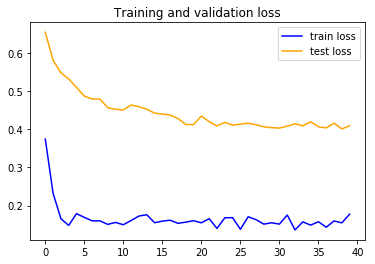

In [37]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'blue', label='train loss')
plt.plot(epochs, val_loss, 'orange', label='test loss')
plt.title('Training and validation loss')
plt.legend()

In [38]:
train_re = train_n.reshape(-1,1,1)
pred = model.predict(train_re)

Since we scaled the data, it is necessary to scale back to data in original units to plot the data

In [39]:
pred = scaler.inverse_transform(pred)

Text(0.5, 1.0, 'Prediction on training data')

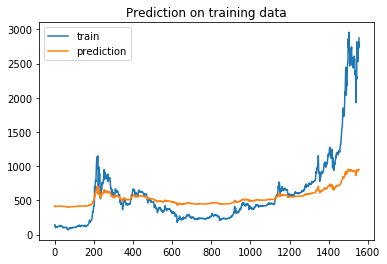

In [40]:
plt.plot(range(len(train_re)), train, label='train')
plt.plot(range(len(train_re)), pred, label='prediction')
plt.legend()
plt.title("Prediction on training data")